# Amharic Character Recognition With CNN


### Importing Libraries


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
plt.rcParams['font.family'] = 'Abyssinica SIL' 


### Loading and Preprocessing Data


In [2]:

class AmharicDataset(Dataset):
    """
    Dataset class for Amharic character recognition
    """
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.images = []
        self.labels = []
        self.label_map = {}
        self.idx_to_class = {}
        
        # Load all images and labels
        self._load_dataset()
    
    def _load_dataset(self):
        """Load images from dataset directory structure"""
        # Get all subdirectories (classes)
        classes = sorted(os.listdir(self.dataset_path))
        
        for i, class_name in enumerate(classes):
            class_dir = os.path.join(self.dataset_path, class_name)
            
            # Skip if not a directory
            if not os.path.isdir(class_dir):
                continue
                
            # Map class name to integer
            self.label_map[class_name] = i
            self.idx_to_class[i] = class_name
            
            # Load images from this class
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                
                # Skip non-image files
                if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue
                
                # Store image path and label
                self.images.append(img_path)
                self.labels.append(i)
        
        print(f"Loaded {len(self.images)} images with {len(self.label_map)} classes")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load and preprocess image
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img = cv2.resize(img, (64, 64))  # Resize to standard size
        
        # Convert to tensor
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        img = torch.from_numpy(img).unsqueeze(0)  # Add channel dimension [1, 64, 64]
        
        # Apply additional transforms if specified
        if self.transform:
            img = self.transform(img)
        
        return img, label
    
    def get_class_info(self):
        return self.label_map, self.idx_to_class


### Model Architecture

In [3]:
class AmharicCNN(nn.Module):
    """
    CNN model for Amharic character classification
    """
    def __init__(self, num_classes):
        super(AmharicCNN, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        # Third Convolutional Block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        
        # Calculate size of flattened feature map
        # Input: 64x64 -> After 3 max pooling: 8x8
        flattened_size = 128 * 8 * 8
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

### Training 

In [4]:

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=50):
    """
    Train the PyTorch model
    """
    # Initialize best validation accuracy
    best_val_acc = 0.0
    best_model_wts = None
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({"loss": loss.item(), "acc": correct/total})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs} => "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()
            # Save model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, 'best_amharic_model.pth')
            print(f"New best model saved with validation accuracy: {val_acc:.4f}")
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Return training history
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs,
        'best_val_acc': best_val_acc
    }
    
    return model, history

def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluate model on the provided dataloader
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def test_model(model, test_loader, device, idx_to_class):
    """
    Test model and compute metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_images = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_images.append(inputs.cpu().numpy())
    
    # Combine image batches
    all_images = np.vstack([img for img in all_images])
    
    # Compute accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    
    # Find the unique classes actually present in the test data
    unique_labels = np.unique(np.array(all_labels))
    
    # Create a mapping of class indices to names for only those classes present in the test data
    present_class_names = {i: idx_to_class[i] for i in unique_labels if i in idx_to_class}
    class_names = [present_class_names[i] for i in sorted(present_class_names.keys())]
    
    # Print metrics
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Found {len(unique_labels)} unique classes in test data")
    
    try:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, labels=sorted(unique_labels), target_names=class_names))
    except Exception as e:
        print(f"Error generating classification report: {e}")
        print("Falling back to basic accuracy metrics")
    
    try:
        # Create confusion matrix - only for classes actually present in the test data
        plt.figure(figsize=(15, 15))
        cm = confusion_matrix(all_labels, all_preds, labels=sorted(unique_labels))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
    except Exception as e:
        print(f"Error generating confusion matrix: {e}")
    
    return accuracy, all_preds, all_labels, all_images

### Visualizing 

In [5]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy
    """
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_predictions(images, true_labels, pred_labels, idx_to_class, num_samples=25):
    """
    Visualize sample predictions
    """
    # Select random samples
    indices = np.random.choice(range(len(images)), min(num_samples, len(images)), replace=False)
    
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(indices):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        
        true_label = idx_to_class[true_labels[idx]]
        pred_label = idx_to_class[pred_labels[idx]]
        
        color = 'green' if true_labels[idx] == pred_labels[idx] else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Loaded 22761 images with 142 classes
Training set: 15932 samples
Validation set: 3414 samples
Test set: 3415 samples
Using device: cuda:0
AmharicCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

/home/hailemicaelyimer/anaconda3/envs/immigration_assistant/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 1/50 => Train Loss: 2.1766, Train Acc: 0.4977, Val Loss: 0.8201, Val Acc: 0.7876
New best model saved with validation accuracy: 0.7876


Epoch 2/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 2/50 => Train Loss: 0.8064, Train Acc: 0.7769, Val Loss: 0.4652, Val Acc: 0.8635
New best model saved with validation accuracy: 0.8635


Epoch 3/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 3/50 => Train Loss: 0.5554, Train Acc: 0.8378, Val Loss: 0.3740, Val Acc: 0.8820
New best model saved with validation accuracy: 0.8820


Epoch 4/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 4/50 => Train Loss: 0.4635, Train Acc: 0.8557, Val Loss: 0.3135, Val Acc: 0.8972
New best model saved with validation accuracy: 0.8972


Epoch 5/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 5/50 => Train Loss: 0.3755, Train Acc: 0.8796, Val Loss: 0.2803, Val Acc: 0.9074
New best model saved with validation accuracy: 0.9074


Epoch 6/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 6/50 => Train Loss: 0.3314, Train Acc: 0.8925, Val Loss: 0.2649, Val Acc: 0.9083
New best model saved with validation accuracy: 0.9083


Epoch 7/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 7/50 => Train Loss: 0.3064, Train Acc: 0.9008, Val Loss: 0.2538, Val Acc: 0.9115
New best model saved with validation accuracy: 0.9115


Epoch 8/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 8/50 => Train Loss: 0.2710, Train Acc: 0.9075, Val Loss: 0.2478, Val Acc: 0.9133
New best model saved with validation accuracy: 0.9133


Epoch 9/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 9/50 => Train Loss: 0.2572, Train Acc: 0.9166, Val Loss: 0.2476, Val Acc: 0.9110


Epoch 10/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 10/50 => Train Loss: 0.2536, Train Acc: 0.9117, Val Loss: 0.2631, Val Acc: 0.9151
New best model saved with validation accuracy: 0.9151


Epoch 11/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 11/50 => Train Loss: 0.2249, Train Acc: 0.9223, Val Loss: 0.2399, Val Acc: 0.9148


Epoch 12/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 12/50 => Train Loss: 0.2048, Train Acc: 0.9300, Val Loss: 0.2514, Val Acc: 0.9174
New best model saved with validation accuracy: 0.9174


Epoch 13/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 13/50 => Train Loss: 0.1956, Train Acc: 0.9323, Val Loss: 0.2489, Val Acc: 0.9183
New best model saved with validation accuracy: 0.9183


Epoch 14/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 14/50 => Train Loss: 0.1906, Train Acc: 0.9328, Val Loss: 0.2285, Val Acc: 0.9224
New best model saved with validation accuracy: 0.9224


Epoch 15/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 15/50 => Train Loss: 0.1808, Train Acc: 0.9361, Val Loss: 0.2525, Val Acc: 0.9133


Epoch 16/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 16/50 => Train Loss: 0.1717, Train Acc: 0.9380, Val Loss: 0.2466, Val Acc: 0.9165


Epoch 17/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 17/50 => Train Loss: 0.1649, Train Acc: 0.9400, Val Loss: 0.2367, Val Acc: 0.9241
New best model saved with validation accuracy: 0.9241


Epoch 18/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 18/50 => Train Loss: 0.1529, Train Acc: 0.9456, Val Loss: 0.2479, Val Acc: 0.9206


Epoch 19/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 19/50 => Train Loss: 0.1492, Train Acc: 0.9463, Val Loss: 0.2442, Val Acc: 0.9218


Epoch 20/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 20/50 => Train Loss: 0.1483, Train Acc: 0.9475, Val Loss: 0.2490, Val Acc: 0.9212


Epoch 21/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 21/50 => Train Loss: 0.1010, Train Acc: 0.9628, Val Loss: 0.2300, Val Acc: 0.9224


Epoch 22/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 22/50 => Train Loss: 0.0836, Train Acc: 0.9695, Val Loss: 0.2252, Val Acc: 0.9288
New best model saved with validation accuracy: 0.9288


Epoch 23/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 23/50 => Train Loss: 0.0792, Train Acc: 0.9713, Val Loss: 0.2268, Val Acc: 0.9268


Epoch 24/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 24/50 => Train Loss: 0.0768, Train Acc: 0.9718, Val Loss: 0.2263, Val Acc: 0.9256


Epoch 25/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 25/50 => Train Loss: 0.0686, Train Acc: 0.9758, Val Loss: 0.2238, Val Acc: 0.9297
New best model saved with validation accuracy: 0.9297


Epoch 26/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 26/50 => Train Loss: 0.0673, Train Acc: 0.9753, Val Loss: 0.2240, Val Acc: 0.9297


Epoch 27/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 27/50 => Train Loss: 0.0653, Train Acc: 0.9756, Val Loss: 0.2233, Val Acc: 0.9262


Epoch 28/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 28/50 => Train Loss: 0.0579, Train Acc: 0.9795, Val Loss: 0.2254, Val Acc: 0.9294


Epoch 29/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 29/50 => Train Loss: 0.0594, Train Acc: 0.9780, Val Loss: 0.2345, Val Acc: 0.9259


Epoch 30/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 30/50 => Train Loss: 0.0556, Train Acc: 0.9797, Val Loss: 0.2310, Val Acc: 0.9300
New best model saved with validation accuracy: 0.9300


Epoch 31/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 31/50 => Train Loss: 0.0541, Train Acc: 0.9812, Val Loss: 0.2251, Val Acc: 0.9288


Epoch 32/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 32/50 => Train Loss: 0.0510, Train Acc: 0.9817, Val Loss: 0.2303, Val Acc: 0.9297


Epoch 33/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 33/50 => Train Loss: 0.0520, Train Acc: 0.9814, Val Loss: 0.2344, Val Acc: 0.9282


Epoch 34/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 34/50 => Train Loss: 0.0461, Train Acc: 0.9844, Val Loss: 0.2337, Val Acc: 0.9303
New best model saved with validation accuracy: 0.9303


Epoch 35/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 35/50 => Train Loss: 0.0452, Train Acc: 0.9830, Val Loss: 0.2306, Val Acc: 0.9309
New best model saved with validation accuracy: 0.9309


Epoch 36/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 36/50 => Train Loss: 0.0423, Train Acc: 0.9852, Val Loss: 0.2329, Val Acc: 0.9303


Epoch 37/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 37/50 => Train Loss: 0.0421, Train Acc: 0.9851, Val Loss: 0.2360, Val Acc: 0.9285


Epoch 38/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 38/50 => Train Loss: 0.0411, Train Acc: 0.9854, Val Loss: 0.2359, Val Acc: 0.9300


Epoch 39/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 39/50 => Train Loss: 0.0428, Train Acc: 0.9845, Val Loss: 0.2329, Val Acc: 0.9300


Epoch 40/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 40/50 => Train Loss: 0.0412, Train Acc: 0.9863, Val Loss: 0.2330, Val Acc: 0.9291


Epoch 41/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 41/50 => Train Loss: 0.0402, Train Acc: 0.9868, Val Loss: 0.2343, Val Acc: 0.9300


Epoch 42/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 42/50 => Train Loss: 0.0430, Train Acc: 0.9840, Val Loss: 0.2328, Val Acc: 0.9309


Epoch 43/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 43/50 => Train Loss: 0.0391, Train Acc: 0.9871, Val Loss: 0.2327, Val Acc: 0.9300


Epoch 44/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 44/50 => Train Loss: 0.0395, Train Acc: 0.9848, Val Loss: 0.2314, Val Acc: 0.9294


Epoch 45/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 45/50 => Train Loss: 0.0395, Train Acc: 0.9863, Val Loss: 0.2323, Val Acc: 0.9297


Epoch 46/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 46/50 => Train Loss: 0.0382, Train Acc: 0.9858, Val Loss: 0.2322, Val Acc: 0.9282


Epoch 47/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 47/50 => Train Loss: 0.0387, Train Acc: 0.9864, Val Loss: 0.2316, Val Acc: 0.9309


Epoch 48/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 48/50 => Train Loss: 0.0378, Train Acc: 0.9874, Val Loss: 0.2332, Val Acc: 0.9291


Epoch 49/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 49/50 => Train Loss: 0.0400, Train Acc: 0.9861, Val Loss: 0.2320, Val Acc: 0.9288


Epoch 50/50:   0%|          | 0/498 [00:00<?, ?it/s]

Epoch 50/50 => Train Loss: 0.0376, Train Acc: 0.9868, Val Loss: 0.2319, Val Acc: 0.9306


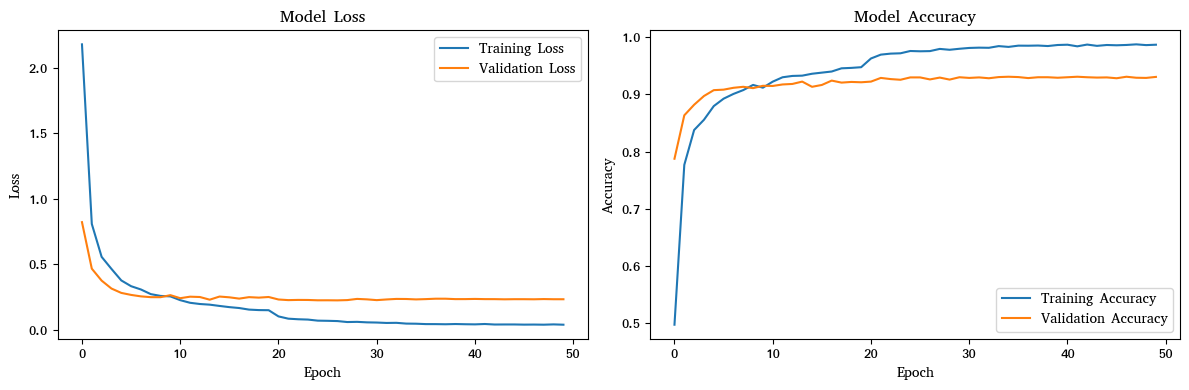

Testing:   0%|          | 0/107 [00:00<?, ?it/s]

Test Accuracy: 0.9344
Found 142 unique classes in test data

Classification Report:
              precision    recall  f1-score   support

           ሀ       1.00      1.00      1.00        29
           ሁ       1.00      1.00      1.00        19
           ሂ       1.00      0.94      0.97        32
           ሃ       0.96      0.96      0.96        23
           ሄ       0.96      0.96      0.96        24
           ህ       1.00      1.00      1.00        25
           ሆ       1.00      1.00      1.00        27
           ለ       0.97      0.80      0.88        35
           ሉ       0.97      0.97      0.97        29
           ሊ       0.90      0.90      0.90        20
           ላ       0.87      0.96      0.92        28
           ሌ       1.00      0.89      0.94        28
           ል       1.00      0.90      0.95        29
           ሎ       0.89      1.00      0.94        17
           ሐ       0.94      0.97      0.95        31
           ሑ       1.00      1.00      1.00        

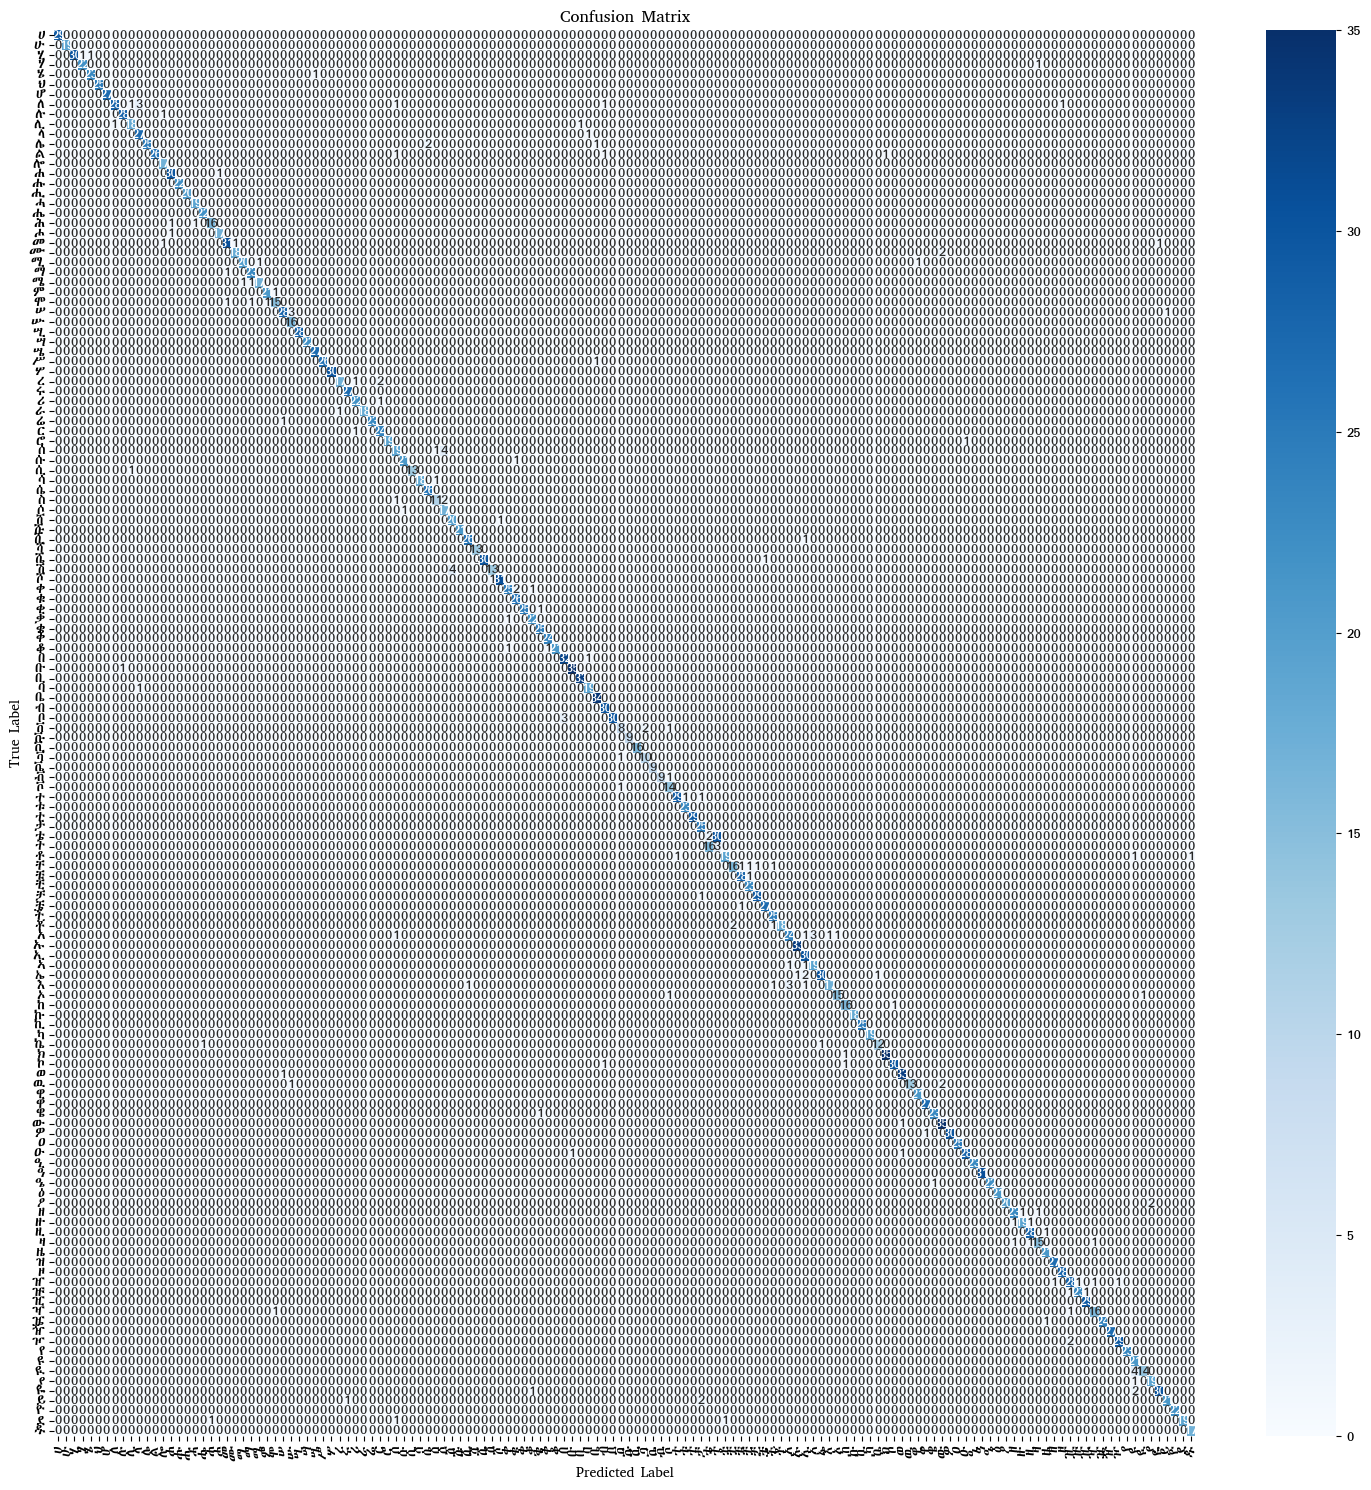

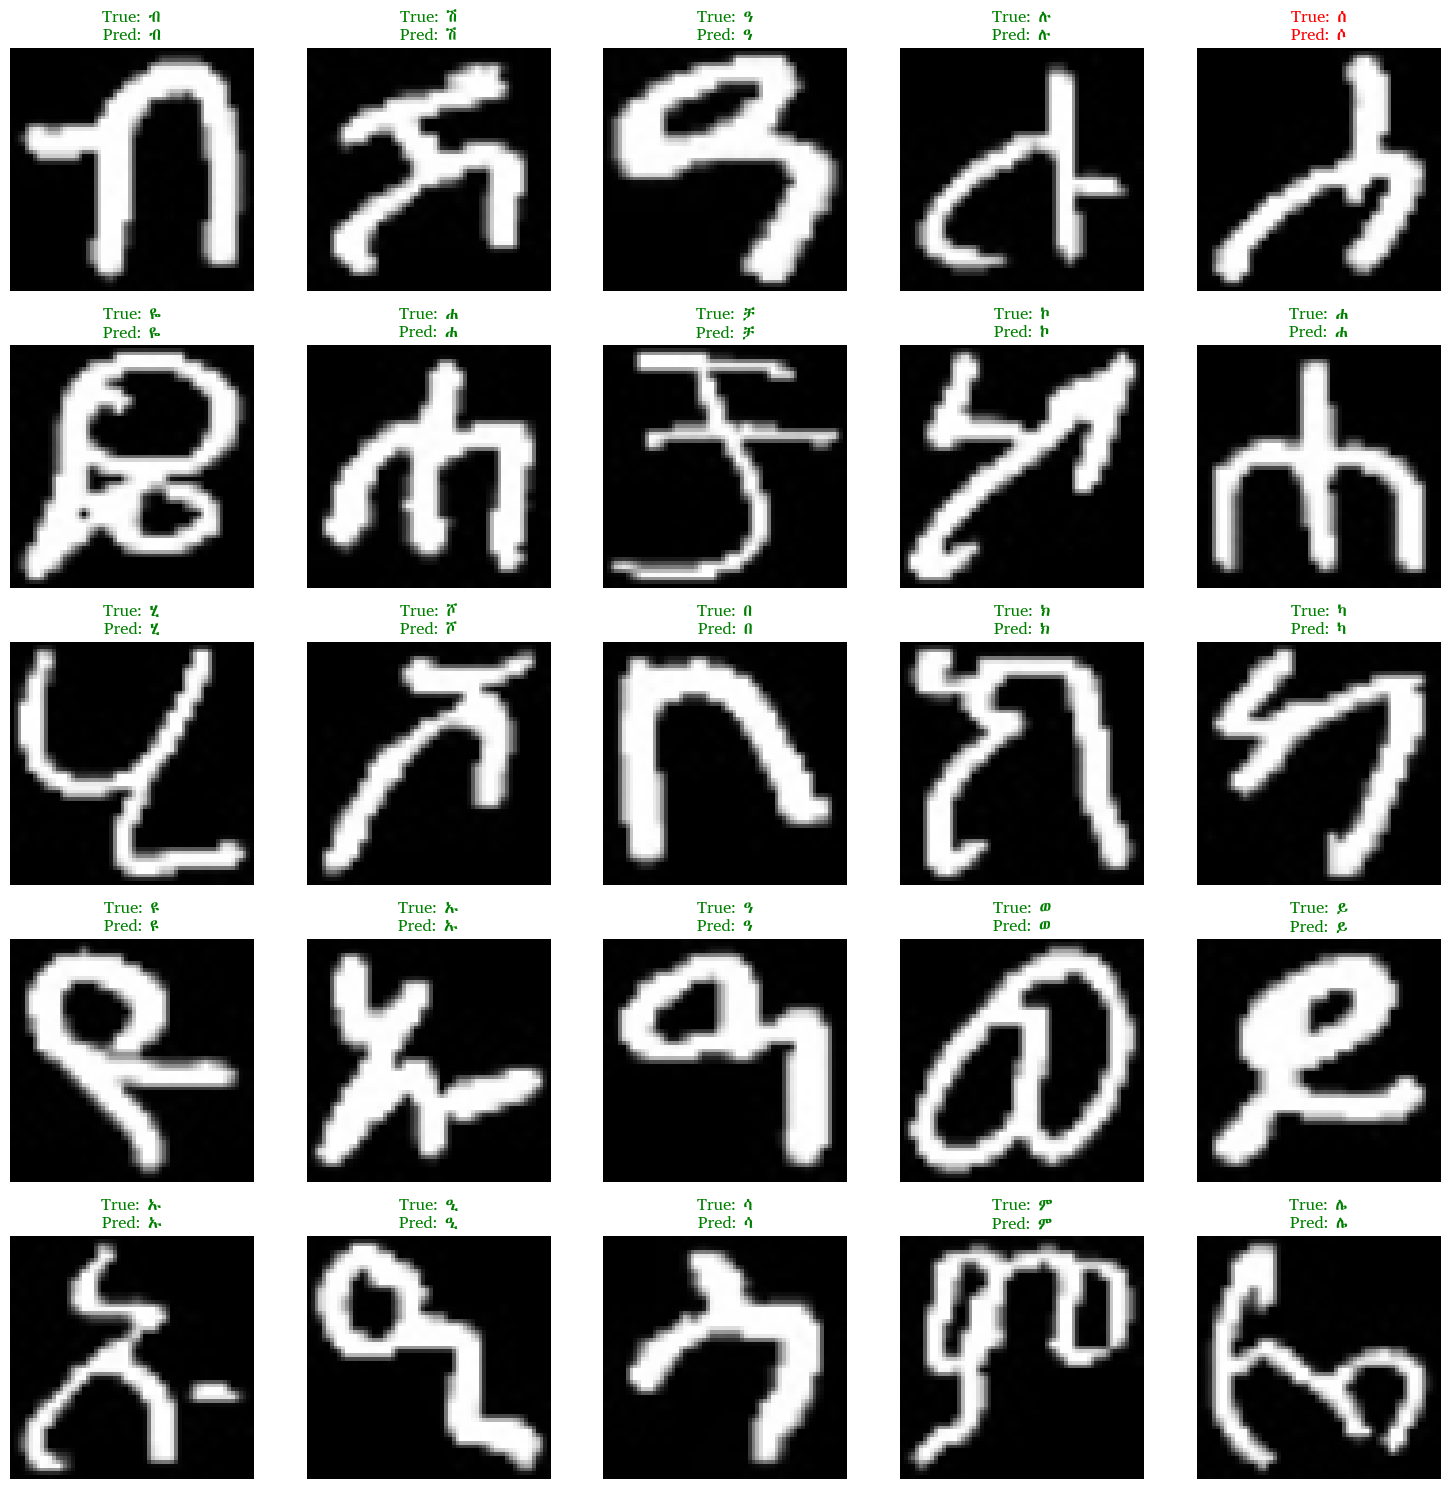

In [6]:
dataset_path = '/home/hailemicaelyimer/Desktop/ACR/dataset'

# Data augmentation transforms for training
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
])

# Create dataset
full_dataset = AmharicDataset(dataset_path)
label_map, idx_to_class = full_dataset.get_class_info()
num_classes = len(label_map)

# Split dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

# Set device (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create model
model = AmharicCNN(num_classes=num_classes)
model = model.to(device)
print(model)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.2, patience=5, verbose=True
)

# Train model
num_epochs = 50
model, history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs
)

# Plot training history
plot_training_history(history)

# Test model
accuracy, all_preds, all_labels, all_images = test_model(model, test_loader, device, idx_to_class)

# Visualize predictions
visualize_predictions(all_images, all_labels, all_preds, idx_to_class)

# Save class mappings for future use
import json
with open('amharic_class_mapping.json', 'w', encoding='utf-8') as f:
    json.dump(label_map, f, ensure_ascii=False, indent=4)